In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# XGBoost 

Set up cross validation, model creation functions and model tuning 

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb

import warnings
warnings.simplefilter('ignore')

## Load Data and Create Features / Labels

In [3]:
df = pd.read_csv('../../data/raw/training.csv', index_col=0)
# df.replace(-1, 99, inplace=True)

X = df.drop(['mobile_money','savings','borrowing','insurance','mobile_money_classification'], axis=1)
y = df['mobile_money_classification']

X.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,...,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Latitude,Longitude
ID,,,,,,,,,,,,,,,,,,,,,
5086,98,2,3,1,1,2,2,0,0,0,...,2,-1,2,-1,1,-1,4,4,-4.460442,29.811396
1258,40,1,1,3,5,1,1,1,0,0,...,1,4,1,5,4,4,1,4,-6.176438,39.244871
331,18,2,4,6,3,2,1,0,0,0,...,2,-1,2,-1,1,-1,1,1,-6.825702,37.652798
6729,50,1,1,3,1,1,1,0,0,0,...,1,2,2,-1,4,-1,1,4,-3.372049,35.808307
8671,34,1,1,1,1,2,1,0,1,0,...,2,-1,1,1,1,-1,1,4,-7.179645,31.039095


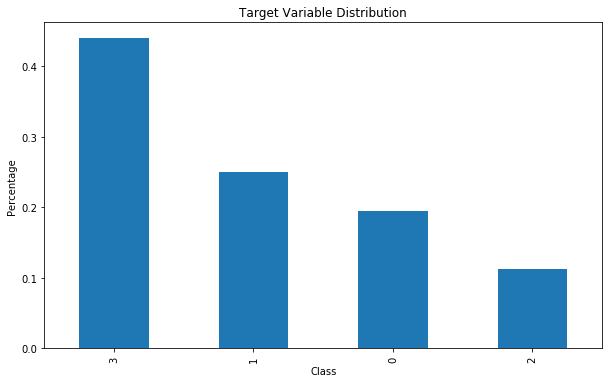

In [4]:
plot = y.value_counts(normalize=True).plot(kind='bar', title='Target Variable Distribution', figsize=(10,6))
plot.set_xlabel('Class')
plot.set_ylabel('Percentage');

## Create XBoost Model

In [5]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier

seed = 2019

np.random.seed(seed)

def zindi_score(y_test, probs):
    """
    Score as we are being scored on LB
    """
    losses = []
    for c in [0,1,2,3]:
        labels = [1 if i == c else 0 for i in y_test]
        loss = log_loss(labels, probs[:, c])
        losses.append(loss)
    return sum(losses)

### Define Model and Starter Parameters

In [6]:
n_classes = y.nunique()

# Params that won't be changed
model_params = {
    'objective': 'multi:softprob', #multiclass classification, but output probabilities not classes
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'seed': 2019
}

# Some default params to start with
starter_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'gamma': 0,
    'min_child_weight': 1,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'scale_pos_weight': 1
}
# Combine parameters sets into one
xgb_params = {**model_params}
xgb_params.update(starter_params)

### Create Preprocessing and Feature Extraction Pipeline(s)

In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from src.features.transformers import ColumnExtractor, MMAgentsInVicinity
from sklearn.feature_selection import VarianceThreshold

from category_encoders import BinaryEncoder

def create_cats(x, cat_vars):
    cats = [list(range(low, high+1)) for low, high in zip(x[cat_vars].min(), x[cat_vars].max())]
    return cats

CONT_VARS = ['Q1']
CAT_VARS = ['Q2','Q3','Q4','Q5','Q6','Q7','Q8_1',
            'Q8_2','Q8_3','Q8_4','Q8_5','Q8_6',
            'Q8_7','Q8_8','Q8_9','Q8_10','Q8_11',
            'Q9','Q10','Q11','Q12','Q13','Q14',
            'Q15','Q16','Q17','Q18','Q19']
LAT_LON = ['Latitude','Longitude']


continuous_pipeline = Pipeline([
        ('extract', ColumnExtractor(CONT_VARS)),
        ('discretize',KBinsDiscretizer(n_bins=7))
])

categorical_pipeline = Pipeline([
        ('extract', ColumnExtractor(CAT_VARS)),
#         ('encode', BinaryEncoder(cols=CAT_VARS)),
])

location_pipeline = Pipeline([
        ('extract', ColumnExtractor(LAT_LON)),
        ('mm_agents_5km', MMAgentsInVicinity(radius=5))
])

# Combine individual pipelines
preprocessing_pipeline = FeatureUnion([
    ('continuous', continuous_pipeline),
    ('categorical', categorical_pipeline),
    ('location', location_pipeline)
])

In [8]:
def modelfit(alg, X, y ,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=y)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='mlogloss', 
                          early_stopping_rounds=early_stopping_rounds, )
        
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y, eval_metric='mlogloss')
        
    #Predict training set:
    X_predictions = alg.predict(X)
    X_predprob = alg.predict_proba(X)
        
    #Print model report:
    print("\nModel Report")
    print("Log Loss : {:.4f}".format(log_loss(y, X_predprob))) 
    print("Zindi Score: {:.4f}".format(zindi_score(y, X_predprob)))
                    
    return alg, cvresult

### Test run with unprocessed features

In [9]:
X_proc = preprocessing_pipeline.fit_transform(X)

In [10]:
model = XGBClassifier(**xgb_params)
model, cv_results = modelfit(model, X_proc, y)


Model Report
Log Loss : 0.6528
Zindi Score: 1.1864


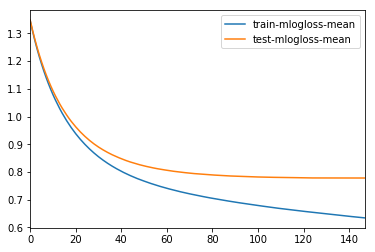

In [11]:
cv_results[['train-mlogloss-mean','test-mlogloss-mean']].plot()

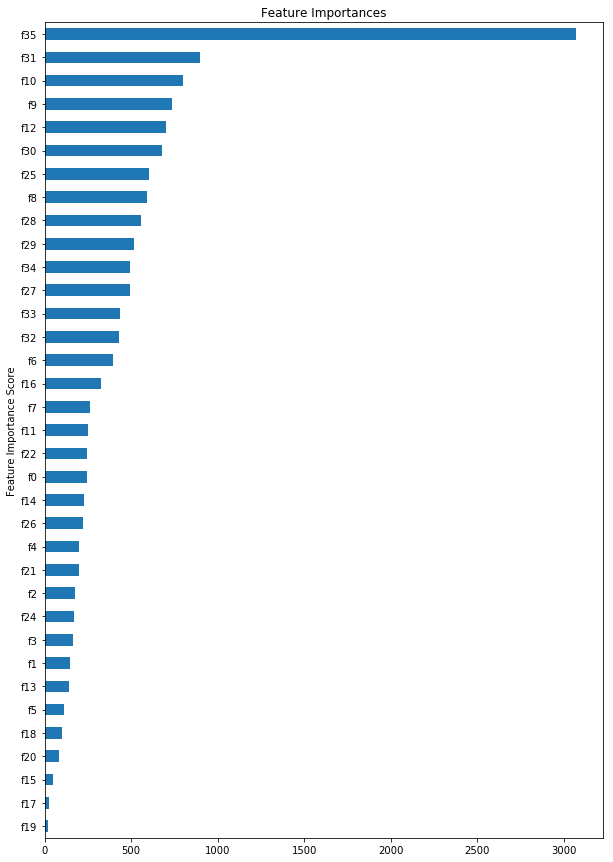

In [12]:
import matplotlib.pyplot as plt
feat_imp = pd.Series(model.get_booster().get_score()).sort_values(ascending=True)
feat_imp.plot.barh(title='Feature Importances', figsize=(10,15))
plt.ylabel('Feature Importance Score');

## Hyper Parameter Tuning

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [14]:
param_test1 = {
    'max_depth':[3,5,7,9],
    'min_child_weight':[1,3,5],
}

gs1 = GridSearchCV(estimator=XGBClassifier(**xgb_params), 
                   param_grid=param_test1, 
                   scoring='neg_log_loss',
                   n_jobs=-1)
gs1.fit(X_proc, y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2019, silent=True, subsample=0.8),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

**Show best score and corresponding params** 

In [15]:
print('Best score: {} with params: {}'.format(gs1.best_score_, gs1.best_params_))

Best score: -0.7780062014022135 with params: {'max_depth': 3, 'min_child_weight': 5}


In [146]:
print('Best score: {} with params: {}'.format(gs1.best_score_, gs1.best_params_))

Best score: -0.776105006435493 with params: {'max_depth': 3, 'min_child_weight': 3}


**Update parameter set with best params**

In [16]:
xgb_params.update(gs1.best_params_)
xgb_params

{'objective': 'multi:softprob',
 'num_class': 4,
 'eval_metric': 'mlogloss',
 'seed': 2019,
 'n_estimators': 500,
 'max_depth': 3,
 'gamma': 0,
 'min_child_weight': 5,
 'learning_rate': 0.05,
 'subsample': 0.8,
 'scale_pos_weight': 1}

In [20]:
gamma_param_set = {
    'gamma': [i/10.0 for i in range(0,11)],
}

gs2 = GridSearchCV(estimator=XGBClassifier(**xgb_params), param_grid=gamma_param_set, scoring='neg_log_loss', n_jobs=-1)
gs2.fit(X_proc, y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2019, silent=True, subsample=0.8),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [21]:
print('Best score: {} with params: {}'.format(gs2.best_score_, gs2.best_params_))

Best score: -0.7751322307824523 with params: {'gamma': 1.0}


In [152]:
print('Best score: {} with params: {}'.format(gs2.best_score_, gs2.best_params_))

Best score: -0.7760532814901704 with params: {'gamma': 0.3}


In [22]:
pd.DataFrame(gs2.cv_results_)[['params','mean_test_score','mean_train_score', 'rank_test_score']]

,params,mean_test_score,mean_train_score,rank_test_score
0,{'gamma': 0.0},-0.778006,-0.638490,11
1,{'gamma': 0.1},-0.777998,-0.638705,10
2,{'gamma': 0.2},-0.777615,-0.638731,8
3,{'gamma': 0.3},-0.777621,-0.638985,9
4,{'gamma': 0.4},-0.777201,-0.639367,5
5,{'gamma': 0.5},-0.777259,-0.639744,6
6,{'gamma': 0.6},-0.777434,-0.640695,7
7,{'gamma': 0.7},-0.776970,-0.642209,4
8,{'gamma': 0.8},-0.776382,-0.644049,3
9,{'gamma': 0.9},-0.776016,-0.646481,2


**Fine-tune Gamma**

In [27]:
gamma_param_set = {
    'gamma': [ 2.5, 2.7, 2.9],
}

gs2 = GridSearchCV(estimator=XGBClassifier(**xgb_params), param_grid=gamma_param_set, scoring='neg_log_loss', n_jobs=-1)
gs2.fit(X_proc, y)

print('Best score: {} with params: {}'.format(gs2.best_score_, gs2.best_params_))
pd.DataFrame(gs2.cv_results_)[['params','mean_test_score','mean_train_score', 'rank_test_score']]

Best score: -0.7680511866240102 with params: {'gamma': 2.7}


,params,mean_test_score,mean_train_score,rank_test_score
0,{'gamma': 2.5},-0.768335,-0.706184,3
1,{'gamma': 2.7},-0.768051,-0.712458,1
2,{'gamma': 2.9},-0.768298,-0.717712,2


In [28]:
xgb_params.update(gs2.best_params_)
xgb_params

{'objective': 'multi:softprob',
 'num_class': 4,
 'eval_metric': 'mlogloss',
 'seed': 2019,
 'n_estimators': 500,
 'max_depth': 3,
 'gamma': 2.7,
 'min_child_weight': 5,
 'learning_rate': 0.05,
 'subsample': 0.8,
 'scale_pos_weight': 1}

In [29]:
subsample_param_set = {
    'subsample': [i/10.0 for i in range(6, 10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)]
}

gs3 = GridSearchCV(
    estimator=XGBClassifier(**xgb_params),
    param_grid=subsample_param_set, 
    scoring='neg_log_loss', 
    n_jobs=-1
)
gs3.fit(X_proc, y)

display(pd.DataFrame(gs3.cv_results_)[['params','mean_test_score','mean_train_score', 'rank_test_score']])

print('\nBest score: {} with params: {}'.format(gs3.best_score_, gs3.best_params_))

xgb_params.update(gs3.best_params_)
xgb_params

,params,mean_test_score,mean_train_score,rank_test_score
0,"{'colsample_bytree': 0.6, 'subsample': 0.6}",-0.767205,-0.718468,3
1,"{'colsample_bytree': 0.6, 'subsample': 0.7}",-0.767554,-0.719195,6
2,"{'colsample_bytree': 0.6, 'subsample': 0.8}",-0.768735,-0.720993,13
3,"{'colsample_bytree': 0.6, 'subsample': 0.9}",-0.769100,-0.725429,16
4,"{'colsample_bytree': 0.7, 'subsample': 0.6}",-0.766959,-0.715478,1
5,"{'colsample_bytree': 0.7, 'subsample': 0.7}",-0.767400,-0.715206,5
6,"{'colsample_bytree': 0.7, 'subsample': 0.8}",-0.767929,-0.717460,10
7,"{'colsample_bytree': 0.7, 'subsample': 0.9}",-0.768608,-0.722898,12
8,"{'colsample_bytree': 0.8, 'subsample': 0.6}",-0.767193,-0.712124,2
9,"{'colsample_bytree': 0.8, 'subsample': 0.7}",-0.767352,-0.713073,4



Best score: -0.7669594196451989 with params: {'colsample_bytree': 0.7, 'subsample': 0.6}


{'objective': 'multi:softprob',
 'num_class': 4,
 'eval_metric': 'mlogloss',
 'seed': 2019,
 'n_estimators': 500,
 'max_depth': 3,
 'gamma': 2.7,
 'min_child_weight': 5,
 'learning_rate': 0.05,
 'subsample': 0.6,
 'scale_pos_weight': 1,
 'colsample_bytree': 0.7}

In [40]:
! pip install scikit-optimize

  Using cached https://files.pythonhosted.org/packages/f4/44/60f82c97d1caa98752c7da2c1681cab5c7a390a0fdd3a55fac672b321cac/scikit_optimize-0.5.2-py2.py3-none-any.whl
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [30]:
reg_param_set = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

gs4 = GridSearchCV(
    estimator=XGBClassifier(**xgb_params),
    param_grid=reg_param_set, 
    scoring='neg_log_loss', 
    n_jobs=-1
)
gs4.fit(X_proc, y)

display(pd.DataFrame(gs4.cv_results_)[['params','mean_test_score','mean_train_score', 'rank_test_score']])

print('\nBest score: {} with params: {}'.format(gs4.best_score_, gs4.best_params_))

xgb_params.update(gs4.best_params_)
xgb_params

,params,mean_test_score,mean_train_score,rank_test_score
0,{'reg_alpha': 1e-05},-0.766959,-0.715478,3
1,{'reg_alpha': 0.01},-0.766898,-0.715816,2
2,{'reg_alpha': 0.1},-0.766834,-0.717145,1
3,{'reg_alpha': 1},-0.767404,-0.731248,4
4,{'reg_alpha': 100},-0.941001,-0.938828,5



Best score: -0.7668343705939371 with params: {'reg_alpha': 0.1}


{'objective': 'multi:softprob',
 'num_class': 4,
 'eval_metric': 'mlogloss',
 'seed': 2019,
 'n_estimators': 500,
 'max_depth': 3,
 'gamma': 2.7,
 'min_child_weight': 5,
 'learning_rate': 0.05,
 'subsample': 0.6,
 'scale_pos_weight': 1,
 'colsample_bytree': 0.7,
 'reg_alpha': 0.1}

In [32]:
reg_param_set = {
    'reg_alpha':  [i/10.0 for i in range(0, 11)]
}

gs4 = GridSearchCV(
    estimator=XGBClassifier(**xgb_params),
    param_grid=reg_param_set, 
    scoring='neg_log_loss', 
    n_jobs=-1
)
gs4.fit(X_proc, y)

display(pd.DataFrame(gs4.cv_results_)[['params','mean_test_score','mean_train_score', 'rank_test_score']])

print('\nBest score: {} with params: {}'.format(gs4.best_score_, gs4.best_params_))
xgb_params.update(gs4.best_params_)
xgb_params

,params,mean_test_score,mean_train_score,rank_test_score
0,{'reg_alpha': 0.0},-0.766959,-0.715478,4
1,{'reg_alpha': 0.1},-0.766834,-0.717145,1
2,{'reg_alpha': 0.2},-0.766860,-0.719213,2
3,{'reg_alpha': 0.3},-0.766924,-0.721086,3
4,{'reg_alpha': 0.4},-0.766998,-0.722555,5
5,{'reg_alpha': 0.5},-0.767206,-0.724275,6
6,{'reg_alpha': 0.6},-0.767350,-0.725800,7
7,{'reg_alpha': 0.7},-0.767435,-0.727417,10
8,{'reg_alpha': 0.8},-0.767353,-0.728912,8
9,{'reg_alpha': 0.9},-0.767555,-0.730024,11



Best score: -0.7668343705939371 with params: {'reg_alpha': 0.1}


{'objective': 'multi:softprob',
 'num_class': 4,
 'eval_metric': 'mlogloss',
 'seed': 2019,
 'n_estimators': 500,
 'max_depth': 3,
 'gamma': 2.7,
 'min_child_weight': 5,
 'learning_rate': 0.05,
 'subsample': 0.6,
 'scale_pos_weight': 1,
 'colsample_bytree': 0.7,
 'reg_alpha': 0.1}

## Hyper Parameter Tuning Using `skopt`

In [53]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from sklearn.model_selection import cross_val_score, StratifiedKFold

from IPython.display import clear_output

class ConvergencePlotCallback(object):
    def __init__(self, figsize=(12,8)):
        self.fig = plt.figure(figsize=figsize)

    def __call__(self, res):
        clear_output(wait=True)
        plot_convergence(res)
        plt.show()
        
skf = StratifiedKFold(n_splits=5)
plot_callback = ConvergencePlotCallback(figsize=(12,8));

<Figure size 864x576 with 0 Axes>

In [54]:
space = [
    Integer(1, 5, name='max_depth'),
    Real(1e-5, 1, "log-uniform", name='learning_rate'),
    Integer(1, 5, name='min_child_weight'),
    Real(0.001, 4, "log-uniform", name='gamma'),
    Real(0.5, 1.0, "uniform", name="subsample"),
    Real(0.5, 1.0, "uniform", name='colsample_bytree'),
    Real(1e-5, 100, "log-uniform", name="reg_alpha")
]

@use_named_args(space)
def objective(**params):
    
    new_params = {**xgb_params}
    new_params.update(**params)
    
    pipeline = Pipeline([
        ('features',preprocessing_pipeline),
        ('classifier', XGBClassifier(**new_params))
    ])
    
    score = -np.mean(cross_val_score(pipeline, X, y, cv=skf, n_jobs=-1, scoring='neg_log_loss'))
    
    return score

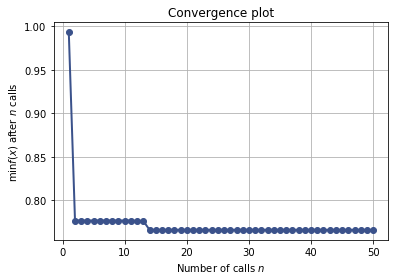

In [55]:
gp_results = gp_minimize(objective, space, n_calls=50, random_state=2019, callback=[plot_callback])

In [69]:
params = ['max_depth','learning_rate','min_child_weight', 'gamma','subsample','colsample_bytree', 'reg_alpha']

opt_params = {}
for param, val in zip(params, gp_results.x):
    print(param, val)
    opt_params[param] = val
    
opt_params

max_depth 2
learning_rate 0.045055093989804396
min_child_weight 5
gamma 0.016880047584747072
subsample 0.5
colsample_bytree 0.5
reg_alpha 0.0007967773809231392


{'max_depth': 2,
 'learning_rate': 0.045055093989804396,
 'min_child_weight': 5,
 'gamma': 0.016880047584747072,
 'subsample': 0.5,
 'colsample_bytree': 0.5,
 'reg_alpha': 0.0007967773809231392}

In [72]:
xgb_params.update(opt_params)

best_model = XGBClassifier(**xgb_params)

best_model.fit(X_proc, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eval_metric='mlogloss',
       gamma=0.016880047584747072, learning_rate=0.045055093989804396,
       max_delta_step=0, max_depth=2, min_child_weight=5, missing=None,
       n_estimators=500, n_jobs=1, nthread=None, num_class=4,
       objective='multi:softprob', random_state=0,
       reg_alpha=0.0007967773809231392, reg_lambda=1, scale_pos_weight=1,
       seed=2019, silent=True, subsample=0.5)

## Make Prediction

In [75]:
from src.utils import make_sub

In [76]:
X_test = pd.read_csv('../../data/raw/test.csv', index_col=0)

X_test_proc = preprocessing_pipeline.transform(X_test)

In [77]:
test_probs = best_model.predict_proba(X_test_proc)

sub_df = make_sub(test_probs)

sub_df.head()

,no_financial_services,other_only,mm_only,mm_plus
2352,0.000266,0.000729,0.218578,0.780427
8208,0.023080,0.046868,0.186810,0.743242
2785,0.000868,0.007127,0.106930,0.885075
2967,0.404901,0.520744,0.019177,0.055178
1697,0.000163,0.001275,0.126783,0.871779


In [78]:
sub_df.to_csv('../../data/submissions/xgb_baseline_tuned.csv')

### Simple train/test split

### Predict on test set